In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.signal import find_peaks
from scipy.ndimage import uniform_filter1d
import copy
from sklearn.decomposition import PCA

from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors

from scipy import stats

### Generate Recording
- Create a recording from a single trace of specified time duration (Poisson spike distribution)

In [2]:
def gen_recording(templates, dur, rate, dt):
    
    dt = dt / 1000 # Convert to ms
    timesteps = int(dur/dt)
    spike_prob = rate * dt
    
    spike_train = np.random.uniform(size=(timesteps, 1)) < spike_prob
    spike_idxs = np.where(spike_train == True)[0]
    
    template_dur = np.shape(templates)[-1]
    
    # Add all spikes into recording
    num_elecs = np.shape(templates)[-2]
    num_fields = np.shape(templates)[0]
    
    recording = np.zeros((num_fields, num_elecs, timesteps))
    
    for i in range(len(spike_idxs)):
        spike_idx = spike_idxs[i]
        if spike_idx + template_dur < timesteps:
            recording[:, :, spike_idx:spike_idx+template_dur] = templates
    
    return recording

### Generate All Recordings

In [17]:
def gen_all_recordings(fields, num_temps, dur, rate, dt):

    temp_indices = np.random.choice(len(fields[0]), num_temps, replace=False)

    recordings = []
    for idx in temp_indices:
        recording = gen_recording(fields[:, idx], dur, rate, dt)
        recordings.append(recording)

    recordings = np.array(recordings)
    
    return recordings

### Load Data

In [60]:
# Get all templates from files

folder_name = 'ziad_mearec_templates/'
mea_name = '100MEA100'

file_name = f'mag_templates_flattened_5-25bound_0-2cells_n300_{mea_name}.npy'
#file_name = 'mag_templates_flattened_5-25bound_2-4cells_n300_Neuropixels-128.npy'
#file_name = 'mag_templates_flattened_5-25bound_2-4cells_n300_Neuropixels-128.npy'

with open(folder_name + file_name, 'rb') as f:
    v = np.load(f)[:, :, :]
    bx = np.load(f)[:, :, :]
    by = np.load(f)[:, :, :]
    bz = np.load(f)[:, :, :]
    locs = np.load(f)
    rots = np.load(f)

addl_files = [f'mag_templates_flattened_5-25bound_2-4cells_n300_{mea_name}.npy',
              f'mag_templates_flattened_5-25bound_4-6cells_n300_{mea_name}.npy']

#addl_files = []

for file in addl_files:
    with open(folder_name + file, 'rb') as f:
        v2 = np.load(f)[:, :, :]
        bx2 = np.load(f)[:, :, :]
        by2 = np.load(f)[:, :, :]
        bz2 = np.load(f)[:, :, :]
        locs2 = np.load(f)
        rots2 = np.load(f) 

        v = np.concatenate((v, v2), axis=0)
        bx = np.concatenate((bx, bx2), axis=0)
        by = np.concatenate((by, by2), axis=0)
        bz = np.concatenate((bz, bz2), axis=0)
        locs = np.concatenate((locs, locs2), axis=0)
        rots = np.concatenate((rots, rots2), axis=0)

fields = np.array([v, bx, by, bz])
print("V: ", np.shape(v))
print("Bx: ", np.shape(bx))
print("By: ", np.shape(by))
print("Bz: ", np.shape(bz))
print("Locations: ", np.shape(locs))
print("Rotations: ", np.shape(rots))

V:  (1800, 100, 224)
Bx:  (1800, 100, 224)
By:  (1800, 100, 224)
Bz:  (1800, 100, 224)
Locations:  (1800, 3)
Rotations:  (1800, 3)


### Condition Number Analysis

In [61]:
#all_temps = [60, 80, 100, 120, 140, 160, 180, 200]
all_temps = [200]

all_s = []

for num_temps in all_temps:
    cell_indices = [2]

    dur = 1        # Duration (s) of fake recording             
    rate = 40      # Spiking rate (Hz) for Poisson process
    dt = 0.03125   # dt of simulation

    iters = 30

    # Store all condition numbers
    conds = np.zeros((4, iters))
    
    # Store all singular values
    s_vals = np.zeros((4, iters, num_temps))
    
    # Create H matrix from flattened recordings for each field
    for j in range(iters):
        print(j)
        
        # Get fields corresponding to specified cells
        num_fields = np.shape(fields)[0]
        total_num_templates = len(cell_indices)*300
        num_elecs = np.shape(fields)[2]
        num_tsteps = np.shape(fields)[3]

        sub_fields = np.zeros((num_fields, total_num_templates, num_elecs, num_tsteps))
        for n, cell_idx in enumerate(cell_indices):
            sub_fields[:, n*300:(n+1)*300] = fields[:, cell_idx*300:(cell_idx+1)*300]

        recordings = gen_all_recordings(sub_fields, num_temps, dur, rate, dt)
            
        for i in range(num_fields):
            
            H = recordings[:, i].reshape((len(recordings), -1))
            H = np.matrix(H / np.linalg.norm(H))
            cov = H * H.getH()

            u, s, vh = np.linalg.svd(cov)
            cond = s[0]/s[-1]
            print(cond)

            conds[i, j] = cond
            s_vals[i, j] = s
        print("")

    print(np.mean(conds, axis=1))
    print(np.std(conds, axis=1))
    all_s.append(s_vals)

0
144.27871342112914
33.58238850578045
2159.358732149065
908.2125272839587

1
113.25330713920233
36.56131841437968
2613.6010494945626
967.2474135276057

2
95.14647911372275
27.82778187502765
1586.3262851044933
904.140389570926

3
106.43400283411876
31.54196139700855
3179.515721393999
799.333279933405

4
61.21971739812804
28.359222546766066
2056.056669653207
667.4354361113916

5
69.2295117628725
42.50910489291264
2360.7106135769845
788.5190815085633

6
95.84210777714915
30.11030753582799
945.2702437482179
828.1191277650115

7
127.48266597643754
27.75977148486224
2585.601971160389
1062.6250770577815

8
51.381548632585115
37.02729554148189
2622.6578493437655
350.1075491493531

9
136.32086962114124
36.639214572441524
1447.1071793328094
1182.8749104441035

10
74.51026122779986
39.68103144576952
1340.4400956030358
923.8346174142888

11
109.45499031621212
38.67530740578
2336.7314482664456
780.6237179692771

12
127.65090954323071
21.5934622546453
1196.6362963473655
1059.4558983785932

13
105.2

### Singular Value Analysis

(-1.0, 100.0)

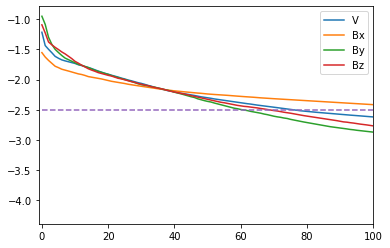

In [74]:
mean_s = np.mean(all_s[0][0], axis=0)
plt.plot(np.log10(mean_s))
mean_s = np.mean(all_s[0][1], axis=0)
plt.plot(np.log10(mean_s))
mean_s = np.mean(all_s[0][2], axis=0)
plt.plot(np.log10(mean_s))
mean_s = np.mean(all_s[0][3], axis=0)
plt.plot(np.log10(mean_s))


# Plot noise
snr = 25
snr = snr/10
noise = np.zeros(np.shape(mean_s)) - snr

plt.plot(noise, '--')

plt.legend(['V', 'Bx', 'By', 'Bz'])
plt.xlim([-1, 100])

In [66]:
idx = 2
vals = np.log10(all_s[0][idx])
means = np.mean(vals, axis=0)
stds = np.std(vals, axis=0)

for i in range(len(means)):
    print(means[i], '\t', stds[i], '\t', str(30))

-0.9550663793906422 	 0.06538048457564419 	 30
-1.100052041223217 	 0.1166926700048988 	 30
-1.3073037804503866 	 0.08740525076098711 	 30
-1.4211735408929553 	 0.06270862408208433 	 30
-1.5020746650652887 	 0.05144980205757794 	 30
-1.5539356555179735 	 0.04829301695753619 	 30
-1.6024973146799912 	 0.04032447026189451 	 30
-1.6449152287495452 	 0.038734842862758335 	 30
-1.6708990346966937 	 0.03492857163191428 	 30
-1.6956726948972751 	 0.029443682609166254 	 30
-1.7255588228617857 	 0.0388898358670185 	 30
-1.7498253617268629 	 0.03804567112428972 	 30
-1.7636852357556234 	 0.03992633240788048 	 30
-1.7833797697101328 	 0.03594760517828408 	 30
-1.800739605754117 	 0.03393881519770392 	 30
-1.8242472855882115 	 0.0370554118356605 	 30
-1.8473850910743828 	 0.036035978832721985 	 30
-1.8654845786117409 	 0.03568141282933739 	 30
-1.882087144922607 	 0.04271776782808147 	 30
-1.8968899357546007 	 0.040435664389403915 	 30
-1.9155139648017991 	 0.03802487252185955 	 30
-1.934569558334

In [67]:
np.shape(templates)

NameError: name 'templates' is not defined